In [1]:
import os, sys, glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import getpass
import subprocess
import time
import importlib
import json
from shutil import copy2
from Bio.PDB import PDBParser, PPBuilder
from Bio import SeqIO
import math
from Bio.PDB import PDBParser
from Bio.PDB.vectors import calc_dihedral
from openpyxl.workbook import Workbook
import seaborn as sns
import random
import re
### Path to this cloned GitHub repo:
SCRIPT_DIR = os.path.dirname("/rds/general/user/wh621/home/heme_binder_diffusion/positive_control.ipynb")  # edit this to the GitHub repo path. Throws an error by default.
assert os.path.exists(SCRIPT_DIR)
sys.path.append(SCRIPT_DIR+"/scripts/utils")
import utils

print(SCRIPT_DIR)
print(sys.path)

/rds/general/user/wh621/home/heme_binder_diffusion
['/rds/general/user/wh621/home/miniforge3/envs/pipeline/lib/python311.zip', '/rds/general/user/wh621/home/miniforge3/envs/pipeline/lib/python3.11', '/rds/general/user/wh621/home/miniforge3/envs/pipeline/lib/python3.11/lib-dynload', '', '/rds/general/user/wh621/home/miniforge3/envs/pipeline/lib/python3.11/site-packages', '/rds/general/user/wh621/home/heme_binder_diffusion/scripts/utils']


In [2]:
diffusion_script = "/rds/general/user/wh621/home/rf_diffusion_all_atom/run_inference.py"  # edit this
inpaint_script = "PATH/TO/RFDesign/inpainting/inpaint.py"  # edit this if needed
proteinMPNN_script = f"{SCRIPT_DIR}/lib/LigandMPNN/run.py"  # from submodule
AF2_script = f"{SCRIPT_DIR}/scripts/af2/af2.py"  # from submodule

print({SCRIPT_DIR})

### Python and/or Apptainer executables needed for running the jobs
### Please provide paths to executables that are able to run the different tasks.
### They can all be the same if you have an environment with all of the ncessary Python modules in one

# If your added Apptainer does not execute scripts directly,
# try adding 'apptainer run' or 'apptainer run --nv' (for GPU) in front of the command

CONDAPATH = "/rds/general/user/wh621/home/miniforge3"   # edit this depending on where your Conda environments live
PYTHON = {"diffusion": f"{CONDAPATH}/envs/diffusion/bin/python",
          "af2": f"{CONDAPATH}/envs/mlfold/bin/python",
          "proteinMPNN": f"{CONDAPATH}/envs/diffusion/bin/python",
          "general": f"{CONDAPATH}/envs/diffusion/bin/python"}

{'/rds/general/user/wh621/home/heme_binder_diffusion'}


In [3]:
username = getpass.getuser()  # your username on the running system
print(username)
EMAIL = f"{username}@ic.ac.uk"  # edit based on your organization. For Slurm job notifications.

PROJECT = "example_Heme_diffusion"

### Path where the jobs will be run and outputs dumped
WDIR = f"{SCRIPT_DIR}/output"

if not os.path.exists(WDIR):
    os.makedirs(WDIR, exist_ok=True)

print(f"Working directory: {WDIR}")

USE_GPU_for_AF2 = True

wh621
Working directory: /rds/general/user/wh621/home/heme_binder_diffusion/output


In [4]:
# Ligand information
params = [f"{SCRIPT_DIR}/theozyme/PCB/PCB.params"]  # Rosetta params file(s)
LIGAND = "PCB"

In [5]:
# Paths
SEQUENCE_DIR = f"{WDIR}/chainbreaker/sequence"
JSON_DIR = f"{WDIR}/chainbreaker/input_json"
DUMP_DIR = f"{WDIR}/chainbreaker/result"

# Use the reference ligand.mol2 file to match all sequences. Not using sdf file as it don't have atom number. 
LIGAND_FILE = '/rds/general/user/wh621/home/heme_binder_diffusion/theozyme/PCB/PCB.mol2' ## Find it locally and upload first!
Ligand_SMILES= 'C/C=C1C(=C/c2[nH]c(/C=c3\[nH]/c(=C\C4=NC(=O)C(CC)=C4C)c(C)c3CCC(=O)O)c(CCC(=O)O)c2C)/NC(=O)[C@@H]/1C'

def makeProtenixJson(sequence, ligand=None, name="JobName", msadir=None):
    """
    Generates a JSON config for Protenix input.
    
    Args:
        sequence (str): Amino acid sequence (1-letter codes).
        ligand (str or list of str): Path(s) to ligand file(s).
        name (str): Job name (used in Protenix output).
        msadir (str): Optional path to MSA directory.

    Returns:
        str: JSON-formatted string.
    """
    protenixConfig = [
        {
            "sequences": [
                {
                    "proteinChain": {
                        "sequence": sequence,
                        "count": 1
                    }
                }
            ],
            "name": name
        }
    ]
    # Add ligand(s) if specified
    if ligand is not None:
        if isinstance(ligand, str):
            ligand = [ligand]
        for lig in ligand:
            # If it's a path to a file (mol2, sdf, etc.), prefix with "FILE_"
            if os.path.isfile(lig):
                lig = f"FILE_{lig}"
            protenixConfig[0]["sequences"].append({
                "ligand": {
                    "ligand": lig,
                    "count": 1
                }
            })

    # Add MSA directory if specified
    if msadir is not None:
        protenixConfig[0]["sequences"][0]["proteinChain"]["msa"] = {
            "precomputed_msa_dir": msadir,
            "pairing_db": "uniref100"
        }
    return json.dumps(protenixConfig, indent=4)

# Ensure output directories exist
os.makedirs(JSON_DIR, exist_ok=True)
os.makedirs(DUMP_DIR, exist_ok=True)

# Get all .fa files in input directory
fasta_files = glob.glob(os.path.join(SEQUENCE_DIR, "*.fa"))
print(f"Found {len(fasta_files)} FASTA files in {SEQUENCE_DIR}.")

# Process each FASTA file
for fasta_file in fasta_files:
    base_name = os.path.basename(fasta_file)
    name = base_name.replace(".fa", "")

    # Read sequence
    record = next(SeqIO.parse(fasta_file, "fasta"))
    sequence = str(record.seq)
    
    # Generate Protenix JSON
    json_content = makeProtenixJson(sequence=sequence, ligand=LIGAND_FILE, name=name)

    # Save JSON
    json_file_path = os.path.join(JSON_DIR, f"{name}.json")
    with open(json_file_path, "w") as f:
        f.write(json_content)

    print(f"Created JSON for {base_name} -> {json_file_path}")

Found 339 FASTA files in /rds/general/user/wh621/home/heme_binder_diffusion/output/chainbreaker/sequence.
Created JSON for 5tou_Chain_I.fa -> /rds/general/user/wh621/home/heme_binder_diffusion/output/chainbreaker/input_json/5tou_Chain_I.json
Created JSON for 7sut_Chain_B.fa -> /rds/general/user/wh621/home/heme_binder_diffusion/output/chainbreaker/input_json/7sut_Chain_B.json
Created JSON for 3o18_Chain_A.fa -> /rds/general/user/wh621/home/heme_binder_diffusion/output/chainbreaker/input_json/3o18_Chain_A.json
Created JSON for 8xf1_Chain_A.fa -> /rds/general/user/wh621/home/heme_binder_diffusion/output/chainbreaker/input_json/8xf1_Chain_A.json
Created JSON for 7eh7_Chain_I.fa -> /rds/general/user/wh621/home/heme_binder_diffusion/output/chainbreaker/input_json/7eh7_Chain_I.json
Created JSON for 1gh0_Chain_B.fa -> /rds/general/user/wh621/home/heme_binder_diffusion/output/chainbreaker/input_json/1gh0_Chain_B.json
Created JSON for 4o4s_Chain_A.fa -> /rds/general/user/wh621/home/heme_binder_d

In [6]:
DUMP_DIR = f"{WDIR}/chainbreaker/result"

# Find all JSON files
json_files = glob.glob(os.path.join(JSON_DIR, "*.json"))
print("Found " + str(len(json_files)) + " JSON files to process in " + JSON_DIR + ".")

commands_protenix = []
cmds_filename_protenix = os.path.join(DUMP_DIR, "commands_protenix")

# Write commands using linear string style
with open(cmds_filename_protenix, "w") as file:
    for json_file in json_files:
        seed = random.randint(101, 20000)
        cmd = "protenix predict --input " + json_file + " --out_dir " + DUMP_DIR + " --seeds " + str(seed) + " --use_esm"
        commands_protenix.append(cmd)
        file.write(cmd + "\n")

print("Example Protenix command:")
print(commands_protenix[-1])
print("Total " + str(len(commands_protenix)) + " commands written to " + cmds_filename_protenix)

submit_script = os.path.join(DUMP_DIR, "submit_protenix.sh")
utils.create_slurm_submit_script(filename=submit_script, name="protenix_job", gpu=True, gres="gpu:a2000:1",
                                 mem="64g", N_cores=4, time="24:00:00", email=EMAIL, group=10,
                                 array=len(commands_protenix), array_commandfile=cmds_filename_protenix)
print(f"PBS submission script '{submit_script}' created.") 
### Notice!! Change it to pipeline environment, NOT diffusion! And Manually fix './/' in head/tail pls..I am being lazy. --Wenhan

Found 339 JSON files to process in /rds/general/user/wh621/home/heme_binder_diffusion/output/chainbreaker/input_json.
Example Protenix command:
protenix predict --input /rds/general/user/wh621/home/heme_binder_diffusion/output/chainbreaker/input_json/4po5_Chain_D.json --out_dir /rds/general/user/wh621/home/heme_binder_diffusion/output/chainbreaker/result --seeds 13333 --use_esm
Total 339 commands written to /rds/general/user/wh621/home/heme_binder_diffusion/output/chainbreaker/result/commands_protenix
PBS submission script '/rds/general/user/wh621/home/heme_binder_diffusion/output/chainbreaker/result/submit_protenix.sh' created.


In [8]:
#collecting Protenix result
sorted_dir = os.path.join(DUMP_DIR, 'sorted')
sorted_json_dir = os.path.join(sorted_dir, 'sorted_json')
sorted_cif_dir = os.path.join(sorted_dir, 'sorted_cif')

os.makedirs(sorted_dir, exist_ok=True)
os.makedirs(sorted_json_dir, exist_ok=True)
os.makedirs(sorted_cif_dir, exist_ok=True)

# Walk through all subdirectories and collect .json and .cif files
for root, dirs, files in os.walk(DUMP_DIR):
    # Skip the 'sorted' directory itself to avoid SameFileError
    if sorted_dir in root:
        continue

    for file in files:
        file_path = os.path.join(root, file)
        if file.endswith('.json'):
            dest_path = os.path.join(sorted_json_dir, file)
        elif file.endswith('.cif'):
            dest_path = os.path.join(sorted_cif_dir, file)
        else:
            continue

        if os.path.abspath(file_path) != os.path.abspath(dest_path):
            copy2(file_path, dest_path)

print("All .json and .cif files have been sorted.")
print("All .json files have been sorted in: ", sorted_json_dir)
print("All .cif files have been sorted in: ", sorted_cif_dir)

All .json and .cif files have been sorted.
All .json files have been sorted in:  /rds/general/user/wh621/home/heme_binder_diffusion/output/chainbreaker/result/sorted/sorted_json
All .cif files have been sorted in:  /rds/general/user/wh621/home/heme_binder_diffusion/output/chainbreaker/result/sorted/sorted_cif


In [9]:
Converted_DIR = f"{WDIR}/chainbreaker/result/converted_pdbs"

# Create output directory if not exists
os.makedirs(Converted_DIR, exist_ok=True)

# BeEM executable
BeEM = '/rds/general/user/wh621/home/BeEM/BeEM'

# Get list of all CIF files
cif_files = glob.glob(os.path.join(sorted_cif_dir, "*.cif"))
print(f"Found {len(cif_files)} CIF files in {sorted_cif_dir}.")

# Process each CIF file
for cif_path in cif_files:
    os.chdir(Converted_DIR)
    # Run BeEM
    command = [BeEM, cif_path]
    subprocess.run(command)

print(f" All .cif files processed. Outputs saved in {Converted_DIR}.")

Found 1040 CIF files in /rds/general/user/wh621/home/heme_binder_diffusion/output/chainbreaker/result/sorted/sorted_cif.
3jbb_chain_h_seed_16726_sample_4_predicted_by_protenix.pdb
1ha7_chain_w_seed_18093_sample_3_predicted_by_protenix.pdb
8xf2_chain_b_seed_12714_sample_1_predicted_by_protenix.pdb
4o4s_chain_c_seed_5790_sample_0_predicted_by_protenix.pdb
4gxe_chain_a_seed_10858_sample_1_predicted_by_protenix.pdb
4o4s_chain_c_seed_5790_sample_4_predicted_by_protenix.pdb
4gxe_chain_a_seed_10858_sample_2_predicted_by_protenix.pdb
8xf2_chain_h_seed_17264_sample_4_predicted_by_protenix.pdb
4xxi_chain_a_seed_18809_sample_3_predicted_by_protenix.pdb
4h0m_chain_d_seed_9894_sample_2_predicted_by_protenix.pdb
8uhe_chain_b_seed_14953_sample_0_predicted_by_protenix.pdb
7sut_chain_e_seed_11684_sample_2_predicted_by_protenix.pdb
1gh0_chain_l_seed_4862_sample_4_predicted_by_protenix.pdb
7efv_chain_b_seed_6639_sample_0_predicted_by_protenix.pdb
3jbb_chain_a_seed_12240_sample_4_predicted_by_protenix.pdb

In [10]:
# Directory containing the JSON files
json_dir = "/rds/general/user/wh621/home/heme_binder_diffusion/output/chainbreaker/result/sorted/sorted_json/"
output_csv = "/rds/general/user/wh621/home/heme_binder_diffusion/output/chainbreaker/result/plddt_summary.csv"

# Collect all .json files
json_files = [f for f in os.listdir(json_dir) if f.endswith(".json")]

# Store data here
data = []

# Process each JSON
for file_name in json_files:
    file_path = os.path.join(json_dir, file_name)
    try:
        with open(file_path, 'r') as f:
            content = json.load(f)
            chain_plddt = content.get("chain_plddt", [])
            if len(chain_plddt) >= 2:
                protein_plddt = chain_plddt[0]
                ligand_plddt = chain_plddt[1]
                data.append({
                    "file_name": file_name,
                    "protein_plddt": protein_plddt,
                    "ligand_plddt": ligand_plddt
                })
            else:
                print(f"Warning: Less than 2 chain_plddt values in {file_name}, skipping.")
    except Exception as e:
        print(f"Error reading {file_name}: {e}")

# Convert to DataFrame and save
df = pd.DataFrame(data)
df.to_csv(output_csv, index=False)
print(f"Saved pLDDT summary to {output_csv}")

Saved pLDDT summary to /rds/general/user/wh621/home/heme_binder_diffusion/output/chainbreaker/result/plddt_summary.csv


protein_plddt      >=   0.900: 408 items left. 408 pass (39%).
ligand_plddt       >=   0.850: 254 items left. 370 pass (36%).


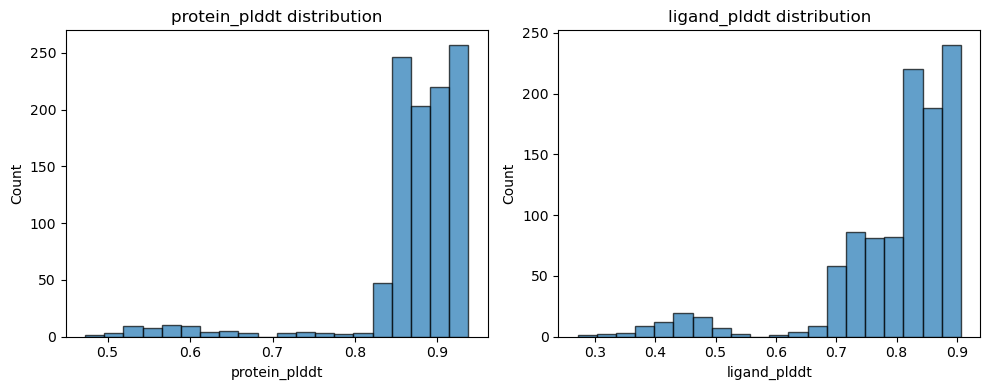

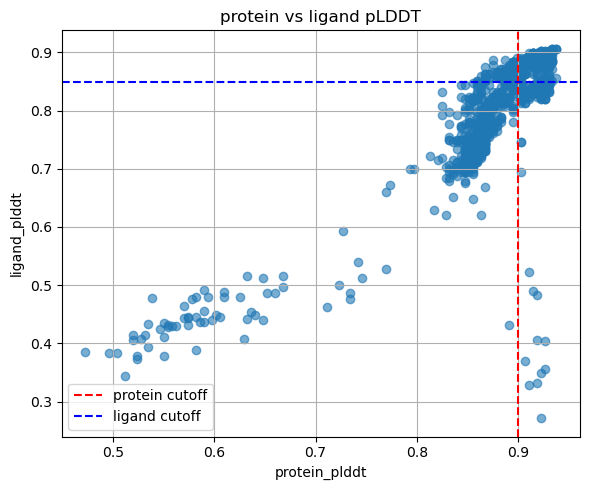

In [12]:
##Step 5: Screening protein_plddt against ligand_plddt in output plddt_summary file
# Load the pLDDT summary CSV
scores = pd.read_csv(output_csv)

# Define filter conditions
# Format: "column_name": [cutoff, operator]
filters = {
    "protein_plddt": [0.90, ">="],
    "ligand_plddt": [0.85, ">="]
}

# Comparison function mapping
comparisons = {
    ">=": "__ge__",
    "<=": "__le__",
    ">": "__gt__",
    "<": "__lt__",
    "=": "__eq__"
}

# Filtering function
def filter_scores(scores, filters):
    filtered_scores = scores.copy()
    for s in filters.keys():
        if filters[s] is not None and s in scores.columns:
            val = filters[s][0]
            sign = comparisons[filters[s][1]]
            filtered_scores = filtered_scores.loc[
                filtered_scores[s].__getattribute__(sign)(val)
            ]
            n_passed = len(scores.loc[scores[s].__getattribute__(sign)(val)])
            print(f"{s:<18} {filters[s][1]:<2} {val:>7.3f}: {len(filtered_scores)} "
                  f"items left. {n_passed} pass ({(n_passed / len(scores)) * 100:.0f}%).")
    return filtered_scores

# Apply filters
filtered_scores = filter_scores(scores, filters)

# Save filtered results
filtered_scores.to_csv("/rds/general/user/wh621/home/heme_binder_diffusion/output/chainbreaker/result/plddt_filtered.csv", index=False)

# Plot histograms
plt.figure(figsize=(10, 4))
for i, k in enumerate(filters):
    plt.subplot(1, 2, i + 1)
    plt.hist(scores[k], bins=20, alpha=0.7, edgecolor='black')
    plt.title(f"{k} distribution")
    plt.xlabel(k)
    plt.ylabel("Count")
plt.tight_layout()
plt.show()

# 2D scatter plot: protein vs ligand pLDDT
plt.figure(figsize=(6, 5))
plt.scatter(scores["protein_plddt"], scores["ligand_plddt"], alpha=0.6)
plt.axvline(filters["protein_plddt"][0], color='red', linestyle='--', label="protein cutoff")
plt.axhline(filters["ligand_plddt"][0], color='blue', linestyle='--', label="ligand cutoff")
plt.xlabel("protein_plddt")
plt.ylabel("ligand_plddt")
plt.title("protein vs ligand pLDDT")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [13]:
#Step 5.5: Copy over to good directory
Converted_DIR = f"{WDIR}/chainbreaker/result/converted_pdbs"
good_dir = os.path.join(Converted_DIR, "good")

# Ensure good directory exists
os.makedirs(good_dir, exist_ok=True)

# Use previously defined `filtered_scores`
assert "file_name" in filtered_scores.columns, "file_name column missing in filtered_scores"

# Track copied files
copied = []

# Process each row from filtered JSONs
for _, row in filtered_scores.iterrows():
    json_file = row["file_name"]

    # Convert JSON name to expected PDB base name
    base = json_file.replace("_summary_confidence", "").replace(".json", "").lower()

    # Expected PDB file name
    pdb_file = f"{base}_predicted_by_protenix.pdb"
    pdb_path = os.path.join(Converted_DIR, pdb_file)

    # Copy if exists
    if os.path.exists(pdb_path):
        copy2(pdb_path, os.path.join(good_dir, pdb_file))
        copied.append(pdb_file)
    else:
        print(f"Warning: PDB not found for {json_file} -> {pdb_file}")

# Final summary
print(f"\n Copied {len(copied)} good PDB files to: {good_dir}")
if len(copied) == 0:
    print(" No valid PDBs were copied. Check your naming logic or paths.")


 Copied 254 good PDB files to: /rds/general/user/wh621/home/heme_binder_diffusion/output/chainbreaker/result/converted_pdbs/good


In [15]:
%%bash
cd /rds/general/user/wh621/home/heme_binder_diffusion/output/chainbreaker/result/converted_pdbs/good
for file in *.pdb; do
  sed -i 's/\bl01\b/PCB/g' "$file"
done
echo 'Job Done, Ligand Name switched'

Job Done, Ligand Name switched


In [6]:
#GALigandDock
os.chdir(WDIR)
Score_GAligandDock = f"{WDIR}/chainbreaker/positive_control_energy"
os.makedirs(Score_GAligandDock, exist_ok=True)
os.chdir(Score_GAligandDock)

holo_pdb_DIR = f"{WDIR}/chainbreaker/result/converted_pdbs"
os.makedirs(Score_GAligandDock+"/logs", exist_ok=True)
NSTRUCT = 10
commands_GAligandDock = []
cmds_filename_des = "commands_GAligandDock"
with open(cmds_filename_des, "w") as file:
    for pdb in glob.glob(f"{holo_pdb_DIR}/*.pdb"):
        commands_GAligandDock.append(f"{PYTHON['general']} {SCRIPT_DIR}/scripts/wenhan/GAligandDock.py "
                             f"--pdb {pdb} --nstruct {NSTRUCT} "
                             f"--params {' '.join(params)} > logs/{os.path.basename(pdb).replace('.pdb', '.log')}\n") 
        file.write(commands_GAligandDock[-1])

print("Example GAligandDock command:")
print(commands_GAligandDock[-1])


### Running design jobs with Slurm.
submit_script = "submit_GAligandDock.sh"
utils.create_slurm_submit_script(filename=submit_script, name="GAligandDock", mem="8g", group=50, 
                                 N_cores=1, time="3:00:00", email=EMAIL, array=len(commands_GAligandDock),
                                 array_commandfile=cmds_filename_des)

Example GAligandDock command:
/rds/general/user/wh621/home/miniforge3/envs/diffusion/bin/python /rds/general/user/wh621/home/heme_binder_diffusion/scripts/wenhan/GAligandDock.py --pdb /rds/general/user/wh621/home/heme_binder_diffusion/output/chainbreaker/result/converted_pdbs/4h0m_chain_p_seed_6881_sample_2_predicted_by_protenix.pdb --nstruct 10 --params /rds/general/user/wh621/home/heme_binder_diffusion/theozyme/PCB/PCB.params > logs/4h0m_chain_p_seed_6881_sample_2_predicted_by_protenix.log



In [9]:
# PyRosetta Ligand All(Heavy) Atom RMSD Calculator (LAAR)
REF_DIR = f"{WDIR}/chainbreaker/result/converted_pdbs/good"
TARGET_DIR = f"{WDIR}/chainbreaker/positive_control_energy/outputs"
AAR_DIR = f"{SCRIPT_DIR}/scripts/wenhan"
DUMP_DIR = f"{WDIR}/chainbreaker/LAAR"
os.makedirs(f"{DUMP_DIR}/logs", exist_ok=True)
os.chdir(DUMP_DIR)

# Match reference and target PDBs
ref_and_model_pairs = []
for ref_pdb in glob.glob(f"{REF_DIR}/*.pdb"):
    ref_basename = os.path.basename(ref_pdb).replace(".pdb", "_").lower()
    for target_pdb in glob.glob(f"{TARGET_DIR}/*.pdb"):
        if ref_basename in os.path.basename(target_pdb).lower():
            ref_and_model_pairs.append((ref_pdb, target_pdb))

assert len(ref_and_model_pairs) > 0, "No reference-target pairs found"
print(f"Matched {len(ref_and_model_pairs)} PDB pairs.")
csv_output_path = os.path.abspath("rmsd_results.csv")
# Generate RMSD commands
commands_rmsd = []
cmds_filename = "commands_rmsd"
with open(cmds_filename, "w") as file:
    for ref_pdb, target_pdb in ref_and_model_pairs:
        cmd = (
            f"RMSD_CSV_PATH={csv_output_path} "
            f"{PYTHON['general']} {AAR_DIR}/all_atom_rmsd.py "
            f"--target_pdb {target_pdb} "
            f"--ref_pdb {ref_pdb} "
            f"--params {' '.join(params)}"
        )
        commands_rmsd.append(cmd)
        file.write(cmd + "\n")

print("Example RMSD command:")
print(commands_rmsd[-1])

submit_script = "submit_aar.sh"
utils.create_slurm_submit_script(filename=submit_script, name="8.1_all_atom_rmsd", mem="8g", 
                                 N_cores=1, time="24:00:00", email=EMAIL, array=len(commands_rmsd), group=10, 
                                 array_commandfile=cmds_filename)
print("PBS submission script created as 'submit_rmsd.sh'")
!realpath submit_rmsd.sh

Matched 486 PDB pairs.
Example RMSD command:
RMSD_CSV_PATH=/rds/general/user/wh621/home/heme_binder_diffusion/output/chainbreaker/LAAR/rmsd_results.csv /rds/general/user/wh621/home/miniforge3/envs/diffusion/bin/python /rds/general/user/wh621/home/heme_binder_diffusion/scripts/wenhan/all_atom_rmsd.py --target_pdb /rds/general/user/wh621/home/heme_binder_diffusion/output/chainbreaker/positive_control_energy/outputs/1phn_chain_a_seed_14477_sample_1_predicted_by_protenix_7.pdb --ref_pdb /rds/general/user/wh621/home/heme_binder_diffusion/output/chainbreaker/result/converted_pdbs/good/1phn_chain_a_seed_14477_sample_1_predicted_by_protenix.pdb --params /rds/general/user/wh621/home/heme_binder_diffusion/theozyme/PCB/PCB.params
PBS submission script created as 'submit_rmsd.sh'
/rds/general/user/wh621/home/heme_binder_diffusion/output/chainbreaker/LAAR/submit_rmsd.sh


In [ ]:
##Single_Calc
os.makedirs("/rds/general/user/wh621/home/heme_binder_diffusion/output/10_good/Excels", exist_ok=True)
PDB_input_dir = "/rds/general/user/wh621/home/heme_binder_diffusion/output/9_galiganddock/outputs"
sigma_angle_file = "/rds/general/user/wh621/home/heme_binder_diffusion/output/10_good/Excels/final_sigma.xlsx"
pdb_files = [os.path.join(PDB_input_dir, f) for f in os.listdir(PDB_input_dir) if f.endswith(".pdb")]
if not pdb_files:
    print(f"No PDB files found in {PDB_input_dir}")
    sys.exit(1)
if os.path.exists(sigma_angle_file):
    angles_df = pd.read_excel(sigma_angle_file)
else:
    angles_df = pd.DataFrame(columns=["File", "Chain_ID", "Residue_Number", "Angle1", "Angle2", "Angle3"])
def find_target_residues(structure):
    target_residues = []
    for model in structure:
        for chain in model:
            for residue in chain:
                if residue.get_resname() == "PCB":  # Adjust this ligand name
                    #print(f"Found target residue: {residue.get_resname()} at chain {chain.id}, residue {residue.id}")
                    target_residues.append((chain.id, residue))
    return target_residues
def get_atom_vector(residue, atom_name):
    if atom_name in residue:
        return residue[atom_name].get_vector()
    else:
        print(f"Warning: Missing atom {atom_name} in residue {residue.get_resname()}. Skipping this calculation.")
        return None
def calculate_torsion(structure, atoms):
    try:
        model = structure[0]

        def get_vector_for_atom(atom_info):
            chain = model[atom_info[0]] if atom_info[0] in model else None
            if not chain:
                print(f"Chain {atom_info[0]} not found.")
                return None
            for res_id, residue in chain.child_dict.items():
                if residue.id[1] == atom_info[1]: 
                    atom_vector = get_atom_vector(residue, atom_info[2])
                    if atom_vector is None:
                        print(f"Atom {atom_info[2]} not found in residue {res_id}")
                    return atom_vector
            print(f"Residue {atom_info[1]} not found in chain {atom_info[0]}")
            return None
        vec1 = get_vector_for_atom(atoms[0])
        vec2 = get_vector_for_atom(atoms[1])
        vec3 = get_vector_for_atom(atoms[2])
        vec4 = get_vector_for_atom(atoms[3])
        if None in [vec1, vec2, vec3, vec4]:
            print("Skipping torsion calculation due to missing atoms.")
            return None  
        torsion_angle = math.degrees(calc_dihedral(vec1, vec2, vec3, vec4))
        return round(torsion_angle, 3)
    except KeyError as e:
        print(f"Error calculating torsion angle: {e}")
        return None
for input_pdb in pdb_files:
    input_pdb_name = os.path.splitext(os.path.basename(input_pdb))[0]
    parser = PDBParser(QUIET=True)
    structure = parser.get_structure("Analysis", input_pdb)
    target_residues = find_target_residues(structure)
    for chain_id, residue in target_residues:
        res_num = residue.id[1]
        torsion_set1 = [(chain_id, res_num, "C24"), (chain_id, res_num, "C21"), (chain_id, res_num, "C12"), (chain_id, res_num, "N2")]
        torsion_set2 = [(chain_id, res_num, "C6"), (chain_id, res_num, "C7"), (chain_id, res_num, "C2"), (chain_id, res_num, "C1")]
        torsion_set3 = [(chain_id, res_num, "C3"), (chain_id, res_num, "C4"), (chain_id, res_num, "C15"), (chain_id, res_num, "C11")]
        angle1 = calculate_torsion(structure, torsion_set1)
        angle2 = calculate_torsion(structure, torsion_set2)
        angle3 = calculate_torsion(structure, torsion_set3)
        new_row = pd.DataFrame({
            "File": [input_pdb_name],
            "Chain_ID": [chain_id],
            "Residue_Number": [res_num],
            "Angle1": [angle1],
            "Angle2": [angle2],
            "Angle3": [angle3]
        })
        angles_df = pd.concat([angles_df, new_row], ignore_index=True)
angles_df.to_excel(sigma_angle_file, index=False)
print(f"Angles data saved to {sigma_angle_file}")

In [ ]:
#Double_Calc
# os.makedirs(os.path.dirname(sigma_angle_file), exist_ok=True)
output_file = "/rds/general/user/wh621/home/heme_binder_diffusion/output/10_good/Excels/final_pi.xlsx"
pdb_files = [os.path.join(PDB_input_dir, f) for f in os.listdir(PDB_input_dir) if f.endswith(".pdb")]
if not pdb_files:
    print(f"No PDB files found in {PDB_input_dir}")
    sys.exit(1)
if os.path.exists(output_file):
    angles_df = pd.read_excel(output_file)
else:
    angles_df = pd.DataFrame(columns=["File", "Chain_ID", "Residue_Number", "Angle1", "Angle2", "Angle3"])
parser = PDBParser(QUIET=True)
def find_target_residues(structure):
    target_residues = []
    for model in structure:
        for chain in model:
            for residue in chain:
                if residue.get_resname() == "PCB":  # Adjust this if necessary: UNK; UNL; BLA; CYC.
                    #print(f"Found target residue: {residue.get_resname()} at chain {chain.id}, residue {residue.id}")
                    target_residues.append((chain.id, residue))
    return target_residues
def get_atom_vector(residue, atom_name):
    if atom_name in residue:
        return residue[atom_name].get_vector()
    else:
        print(f"Warning: Missing atom {atom_name} in residue {residue.get_resname()}. Skipping this calculation.")
        return None
def calculate_torsion(structure, atoms):
    try:
        model = structure[0]

        def get_vector_for_atom(atom_info):
            """ Retrieves atom vector correctly for both standard residues and heteroatoms """
            chain = model[atom_info[0]] if atom_info[0] in model else None
            if not chain:
                print(f"Chain {atom_info[0]} not found.")
                return None
            for res_id, residue in chain.child_dict.items():
                if residue.id[1] == atom_info[1]:  # Match residue number
                    atom_vector = get_atom_vector(residue, atom_info[2])
                    if atom_vector is None:
                        print(f"Atom {atom_info[2]} not found in residue {res_id}")
                    return atom_vector
            print(f"Residue {atom_info[1]} not found in chain {atom_info[0]}")
            return None
        vec1 = get_vector_for_atom(atoms[0])
        vec2 = get_vector_for_atom(atoms[1])
        vec3 = get_vector_for_atom(atoms[2])
        vec4 = get_vector_for_atom(atoms[3])
        if None in [vec1, vec2, vec3, vec4]:
            print("Skipping torsion calculation due to missing atoms.")
            return None  
        torsion_angle = math.degrees(calc_dihedral(vec1, vec2, vec3, vec4))
        return round(torsion_angle, 3)
    except KeyError as e:
        print(f"Error calculating torsion angle: {e}")
        return None
for input_pdb in pdb_files:
    input_pdb_name = os.path.splitext(os.path.basename(input_pdb))[0]
    structure = parser.get_structure("Analysis", input_pdb)
    target_residues = find_target_residues(structure)
    for chain_id, residue in target_residues:
        res_num = residue.id[1]
        torsion_set1 = [(chain_id, res_num, "C25"), (chain_id, res_num, "C24"), (chain_id, res_num, "C21"), (chain_id, res_num, "C12")]
        torsion_set2 = [(chain_id, res_num, "C5"), (chain_id, res_num, "C6"), (chain_id, res_num, "C7"), (chain_id, res_num, "C2")]
        torsion_set3 = [(chain_id, res_num, "C13"), (chain_id, res_num, "C11"), (chain_id, res_num, "C15"), (chain_id, res_num, "C4")]
        angle1 = calculate_torsion(structure, torsion_set1)
        angle2 = calculate_torsion(structure, torsion_set2)
        angle3 = calculate_torsion(structure, torsion_set3)
        new_row = pd.DataFrame({
            "File": [input_pdb_name],
            "Chain_ID": [chain_id],
            "Residue_Number": [res_num],
            "Angle1": [angle1],
            "Angle2": [angle2],
            "Angle3": [angle3]
        })
        angles_df = pd.concat([angles_df, new_row], ignore_index=True)
angles_df.to_excel(output_file, index=False)
print(f"Angles data saved to {output_file}")

In [16]:
from Bio.PDB import PDBParser, PDBIO
import os

def extract_ligand_from_pdb_dir(input_dir, output_dir, chain_id=None):
    """
    Extracts the last residue (usually the ligand) from each PDB file in a directory.

    Parameters:
    - input_dir: Directory containing PDB files.
    - output_dir: Directory to save extracted ligand files.
    - chain_id: Optional chain ID to use. If None, uses the first chain.
    """
    parser = PDBParser(QUIET=True)
    io = PDBIO()

    # Create output directory if it doesn't exist
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Process each PDB file
    for pdb_file in os.listdir(input_dir):
        if pdb_file.endswith('.pdb'):
            pdb_path = os.path.join(input_dir, pdb_file)
            structure = parser.get_structure(pdb_file[:-4], pdb_path)
            model = structure[0]

            # Use specified chain or first chain
            if chain_id:
                if chain_id not in model:
                    print(f"Chain {chain_id} not found in {pdb_file}, skipping.")
                    continue
                chain = model[chain_id]
            else:
                chain = list(model.get_chains())[0]

            residues = list(chain.get_residues())
            if not residues:
                print(f"No residues found in {pdb_file}, skipping.")
                continue

            # Extract the last residue (assumed to be the ligand)
            ligand_res = residues[-1]
            ligand_name = ligand_res.get_resname().strip()
            output_filename = f"{pdb_file[:-4]}.pdb"
            output_path = os.path.join(output_dir, output_filename)

            # Save the ligand residue
            io.set_structure(ligand_res)
            io.save(output_path)
            print(f"Saved ligand to {output_filename}")

# Example usage
input_directory = '/rds/general/user/wh621/home/heme_binder_diffusion/output/chainbreaker/positive_control_energy/outputs/'        # Folder with original PDBs
output_directory = '/rds/general/user/wh621/home/heme_binder_diffusion/output/chainbreaker/positive_control_energy/outputs/ligand_only/'     # Folder to save extracted ligands
extract_ligand_from_pdb_dir(input_directory, output_directory, chain_id= 'B' )

Saved ligand to 5tou_chain_l_seed_2137_sample_0_predicted_by_protenix_0.pdb
Saved ligand to 4f0t_chain_b_seed_5184_sample_0_predicted_by_protenix_9.pdb
Saved ligand to 7eh7_chain_p_seed_3935_sample_4_predicted_by_protenix_7.pdb
Saved ligand to 7efw_chain_f_seed_1361_sample_2_predicted_by_protenix_3.pdb
Saved ligand to 7eh8_chain_b_seed_4313_sample_4_predicted_by_protenix_0.pdb
Saved ligand to 1i7y_chain_b_seed_3585_sample_4_predicted_by_protenix_3.pdb
Saved ligand to 7efw_chain_d_seed_4591_sample_3_predicted_by_protenix_8.pdb
Saved ligand to 1i7y_chain_b_seed_3585_sample_3_predicted_by_protenix_8.pdb
Saved ligand to 2bv8_chain_f_seed_491_sample_0_predicted_by_protenix_2.pdb
Saved ligand to 4f0t_chain_b_seed_5184_sample_0_predicted_by_protenix_2.pdb
Saved ligand to 1gh0_chain_t_seed_2106_sample_1_predicted_by_protenix_5.pdb
Saved ligand to 4gy3_chain_a_seed_7346_sample_1_predicted_by_protenix_3.pdb
Saved ligand to 4f0u_chain_e_seed_10620_sample_2_predicted_by_protenix_3.pdb
Saved ligand

In [17]:
input_directory = '/rds/general/user/wh621/home/heme_binder_diffusion/output/chainbreaker/result/converted_pdbs/good/'        # Folder with original PDBs
output_directory = '/rds/general/user/wh621/home/heme_binder_diffusion/output/chainbreaker/result/converted_pdbs/good/ligand_only/'     # Folder to save extracted ligands
extract_ligand_from_pdb_dir(input_directory, output_directory, chain_id= 'B' )

Saved ligand to 4h0m_chain_f_seed_11499_sample_3_predicted_by_protenix.pdb
Saved ligand to 2bv8_chain_f_seed_491_sample_1_predicted_by_protenix.pdb
Saved ligand to 3o18_chain_b_seed_15250_sample_1_predicted_by_protenix.pdb
Saved ligand to 4h0m_chain_l_seed_1395_sample_1_predicted_by_protenix.pdb
Saved ligand to 3jbb_chain_i_seed_15999_sample_2_predicted_by_protenix.pdb
Saved ligand to 4f0u_chain_e_seed_10620_sample_0_predicted_by_protenix.pdb
Saved ligand to 8uhe_chain_g_seed_9451_sample_3_predicted_by_protenix.pdb
Saved ligand to 1phn_chain_b_seed_2060_sample_0_predicted_by_protenix.pdb
Saved ligand to 8uhe_chain_i_seed_19442_sample_0_predicted_by_protenix.pdb
Saved ligand to 4h0m_chain_f_seed_11499_sample_2_predicted_by_protenix.pdb
Saved ligand to 5tou_chain_d_seed_15694_sample_3_predicted_by_protenix.pdb
Saved ligand to 7sut_chain_b_seed_18740_sample_3_predicted_by_protenix.pdb
Saved ligand to 8xf1_chain_a_seed_7865_sample_4_predicted_by_protenix.pdb
Saved ligand to 1ktp_chain_b_se

In [19]:
# PyRosetta RDKiT RMSD Calculator
REF_DIR = '/rds/general/user/wh621/home/heme_binder_diffusion/output/chainbreaker/result/converted_pdbs/good/ligand_only/' 
TARGET_DIR = '/rds/general/user/wh621/home/heme_binder_diffusion/output/chainbreaker/positive_control_energy/outputs/ligand_only/'
AAR_DIR = f"{SCRIPT_DIR}/scripts/wenhan"
DUMP_DIR = f"{WDIR}/chainbreaker/rmsd_ref"
os.makedirs(f"{DUMP_DIR}/logs", exist_ok=True)
os.chdir(DUMP_DIR)

# Match reference and target PDBs
ref_and_model_pairs = []
for ref_pdb in glob.glob(f"{REF_DIR}/*.pdb"):
    ref_basename = os.path.basename(ref_pdb).replace(".pdb", "_").lower()
    for target_pdb in glob.glob(f"{TARGET_DIR}/*.pdb"):
        if ref_basename in os.path.basename(target_pdb).lower():
            ref_and_model_pairs.append((ref_pdb, target_pdb))

assert len(ref_and_model_pairs) > 0, "No reference-target pairs found"
print(f"Matched {len(ref_and_model_pairs)} PDB pairs.")
csv_output_path = os.path.abspath("rdkit_results.csv")
# Generate RMSD commands
commands_rmsd = []
cmds_filename = "commands_rmsd"
with open(cmds_filename, "w") as file:
    for ref_pdb, target_pdb in ref_and_model_pairs:
        cmd = (
            f"RMSD_CSV_PATH={csv_output_path} "
            f"{PYTHON['general']} {AAR_DIR}/normal_rmsd.py "
            f"--target_pdb {target_pdb} "
            f"--ref_pdb {ref_pdb} "
            f"--params {' '.join(params)}"
        )
        commands_rmsd.append(cmd)
        file.write(cmd + "\n")

print("Example RMSD command:")
print(commands_rmsd[-1])

submit_script = "submit_rdkit.sh"
utils.create_slurm_submit_script(filename=submit_script, name="rdkit", mem="8g", 
                                 N_cores=1, time="24:00:00", email=EMAIL, array=len(commands_rmsd), group=10, 
                                 array_commandfile=cmds_filename)
print("PBS submission script created as 'submit_rdkit.sh'")
!realpath submit_rdkit.sh

Matched 486 PDB pairs.
Example RMSD command:
RMSD_CSV_PATH=/rds/general/user/wh621/home/heme_binder_diffusion/output/chainbreaker/rmsd_ref/rdkit_results.csv /rds/general/user/wh621/home/miniforge3/envs/diffusion/bin/python /rds/general/user/wh621/home/heme_binder_diffusion/scripts/wenhan/normal_rmsd.py --target_pdb /rds/general/user/wh621/home/heme_binder_diffusion/output/chainbreaker/positive_control_energy/outputs/ligand_only/1phn_chain_a_seed_14477_sample_1_predicted_by_protenix_7.pdb --ref_pdb /rds/general/user/wh621/home/heme_binder_diffusion/output/chainbreaker/result/converted_pdbs/good/ligand_only/1phn_chain_a_seed_14477_sample_1_predicted_by_protenix.pdb --params /rds/general/user/wh621/home/heme_binder_diffusion/theozyme/PCB/PCB.params
PBS submission script created as 'submit_rdkit.sh'
/rds/general/user/wh621/home/heme_binder_diffusion/output/chainbreaker/rmsd_ref/submit_rdkit.sh


In [ ]:
ref_csv = '/rds/general/user/wh621/home/heme_binder_diffusion/output/chainbreaker/positive_control_energy/outputs/Scoring.csv'
new_csv = '/rds/general/user/wh621/home/heme_binder_diffusion/output/chainbreaker/positive_control_energy/outputs/cleaned_scoring.csv'
def clean_csv_columns(input_path, output_path, keep_columns=4):
    with open(input_path, 'r', newline='') as infile, open(output_path, 'w', newline='') as outfile:
        reader = csv.reader(infile)
        writer = csv.writer(outfile)

        for row in reader:
            writer.writerow(row[:keep_columns])
clean_csv_columns(ref_csv, new_csv, keep_columns=4)
df = pd.read_csv(new_csv)

# Create subplots: Left for total_score, Right for score_per_res
plt.figure(figsize=(12, 5))

# Left subplot - total_score
plt.subplot(1, 2, 1)
plt.hist(df['total_score'], bins=30, color='yellow', edgecolor='black')
plt.xlabel('total_score')
plt.ylabel('Count')
plt.title('Histogram of total_score')

# Right subplot - score_per_res with red dashed line at x=-1.8
plt.subplot(1, 2, 2)
plt.hist(df['score_per_res'], bins=50, color='yellow', edgecolor='black')
plt.axvline(x=-1.2, color='red', linestyle='--', linewidth=2, label='Cutoff = -1.2')
plt.xlabel('score_per_res')
plt.ylabel('Count')
plt.title('Histogram of score_per_res')
plt.legend()

# Display both plots
plt.tight_layout()
plt.show()